In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import itertools
import numpy as np                      # numpy normal para preparar datos
import jax
import jax.numpy as jnp                 # jax numpy para el modelo
from jax import random, grad, jit, vmap, hessian
from jax.example_libraries import optimizers
from functools import partial
from tqdm.auto import trange

# -----------------------------------------------------------------------------
# 1. MLP y utilidades
# -----------------------------------------------------------------------------

def glorot_init(key, shape):
    in_dim, out_dim = shape
    limit = jnp.sqrt(6.0 / (in_dim + out_dim))
    return random.uniform(key, shape, minval=-limit, maxval=limit)

def MLP(layer_sizes, activation=jnp.tanh, out_activation=None):
    """
    Retorna (init_fun, apply_fun) para un MLP fully-connected.
    """
    def init_fun(rng_key):
        params = []
        keys = random.split(rng_key, len(layer_sizes) - 1)
        for k, (m, n) in zip(keys, zip(layer_sizes[:-1], layer_sizes[1:])):
            W = glorot_init(k, (m, n))
            b = jnp.zeros((n,))
            params.append((W, b))
        return params

    def apply_fun(params, x):
        # x: (..., input_dim)
        for i, (W, b) in enumerate(params):
            x = jnp.dot(x, W) + b
            if i < len(params) - 1:
                x = activation(x)
            else:
                if out_activation is not None:
                    x = out_activation(x)
        return x

    return init_fun, apply_fun

def modified_MLP(layer_sizes, activation=jnp.tanh, out_activation=None):
    """
    Versión simple para usar como branch/trunk net.
    """
    return MLP(layer_sizes, activation=activation, out_activation=out_activation)

# -----------------------------------------------------------------------------
# 2. DataGenerator (batching)
# -----------------------------------------------------------------------------

class DataGenerator:
    """
    Generador de batches al estilo PyTorch, pero simple.
    inputs: (U, X)  -> U: (N, m), X: (N, d)
    outputs: S: (N, 1)
    """
    def __init__(self, U, X, S, batch_size, shuffle=True):
        self.U = U
        self.X = X
        self.S = S
        self.N = U.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self._reset()

    def _reset(self):
        self.indices = np.arange(self.N)
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.ptr = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.ptr + self.batch_size > self.N:
            # Reiniciamos epoch
            self._reset()
        idx = self.indices[self.ptr:self.ptr + self.batch_size]
        self.ptr += self.batch_size

        U_batch = jnp.array(self.U[idx])
        X_batch = jnp.array(self.X[idx])
        S_batch = jnp.array(self.S[idx])

        return (U_batch, X_batch), S_batch

# -----------------------------------------------------------------------------
# 3. Modelo: PI_DeepONet para ecuación de onda acústica 2D
# -----------------------------------------------------------------------------

class PI_DeepONet_Acoustic:
    """
    DeepONet físicamente informado para la ecuación de onda acústica 2D:

        (1 / c(x,z)^2) * p_tt - (p_xx + p_zz) = 0

    Branch net:    u (modelo de velocidad aplanado)   -> B(u)
    Trunk net:     (x,z,t)                            -> T(x,z,t)
    Operador:      p(x,z,t) = sum_k B_k(u) * T_k(x,z,t)
    """
    def __init__(self, branch_layers, trunk_layers, Nx, Nz,
                 lr=1e-3, decay_steps=2000, decay_rate=0.9):
        self.Nx = Nx
        self.Nz = Nz

        # Definición de redes
        self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=jnp.tanh)
        self.trunk_init,  self.trunk_apply  = modified_MLP(trunk_layers,  activation=jnp.tanh)

        # Inicialización de parámetros
        key1, key2 = random.split(random.PRNGKey(1234))
        branch_params = self.branch_init(key1)
        trunk_params  = self.trunk_init(key2)
        params = (branch_params, trunk_params)

        # Optimizador Adam con decaimiento exponencial
        schedule = optimizers.exponential_decay(lr, decay_steps=decay_steps,
                                                decay_rate=decay_rate)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(schedule)
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()

        # Logs (opcionales)
        self.loss_log   = []
        self.loss_res   = []
        self.loss_pc_log    = []
        self.loss_bc_log    = []
        self.loss_data_log  = []

    # ------------------------ DeepONet ------------------------

    def operator_net(self, params, u, xzt):
        """
        u:   (m,)             modelo de velocidad aplanado
        xzt: (3,)             (x, z, t) en índices de grilla
        """
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)    # (m_hidden,)
        T = self.trunk_apply(trunk_params, xzt)    # (m_hidden,)
        return jnp.sum(B * T)                      # escalar p

    def get_c_from_u(self, u, xzt):
        """
        Extrae c(x,z) desde u aplanado.
        Aquí suponemos que x,z son índices de grilla [0..Nx-1], [0..Nz-1].
        """
        x, z, t = xzt
        c_grid = u.reshape(self.Nz, self.Nx)  # (Nz, Nx)

        i = jnp.clip(jnp.round(x).astype(jnp.int32), 0, self.Nx - 1)
        j = jnp.clip(jnp.round(z).astype(jnp.int32), 0, self.Nz - 1)

        return c_grid[j, i]

    def pde_net(self, params, u, xzt):
        """
        pde de la ecuación de onda acústica:
            r = (1/c^2) * p_tt - (p_xx + p_zz)
        """
        def net_xzt(X):
            return self.operator_net(params, u, X)

        # Hessiano completo wrt [x,z,t], X=(x,z,t)
        H = hessian(net_xzt)(xzt)    # (3, 3)
        p_xx = H[0, 0]
        p_zz = H[1, 1]
        p_tt = H[2, 2]

        c = self.get_c_from_u(u, xzt)
        r = (1.0 / (c**2 + 1e-8)) * p_tt - (p_xx + p_zz)
        return r

    # ------------------------ Predicciones vectorizadas ------------------------

    @partial(jit, static_argnums=(0,))
    def predict_p(self, params, U_star, XZT_star):
        """
        U_star:    (N_points, m)
        XZT_star:  (N_points, 3)
        """
        return vmap(self.operator_net, (None, 0, 0))(params, U_star, XZT_star)

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, XZT_star):
        return vmap(self.pde_net, (None, 0, 0))(params, U_star, XZT_star)

    # ------------------------ Funciones de pérdida ------------------------

    def loss_pde(self, params, batch):
        (u, xzt), s_target = batch   # s_target ~ 0
        r_pred = vmap(self.pde_net, (None, 0, 0))(params, u, xzt)
        return jnp.mean(r_pred**2)

    def loss_pc(self, params, batch):
        (u, xzt), s_target = batch   # p(x,z,0) = 0
        p_pred = vmap(self.operator_net, (None, 0, 0))(params, u, xzt)
        return jnp.mean((s_target.flatten() - p_pred)**2)

    def loss_bc(self, params, batch):
        (u, xzt), s_target = batch   # shotgather
        p_pred = vmap(self.operator_net, (None, 0, 0))(params, u, xzt)
        return jnp.mean((s_target.flatten() - p_pred)**2)

    def loss_data(self, params, batch):
        (u, xzt), s_target = batch   # snapshots internos
        p_pred = vmap(self.operator_net, (None, 0, 0))(params, u, xzt)
        return jnp.mean((s_target.flatten() - p_pred)**2)

    def total_loss(self, params, res_batch, pc_batch, bc_batch, data_batch,
                   w_res=10.0, wpc=1.0, w_bc=10.0, w_data=10.0):
        L_res  = self.loss_pde(params, res_batch)
        L_pc   = self.loss_pc(params, pc_batch)
        L_bc   = self.loss_bc(params, bc_batch)
        L_data = self.loss_data(params, data_batch)

        total = w_res*L_res + wpc*L_pc + w_bc*L_bc + w_data*L_data

        return total, (L_res, L_pc, L_bc, L_data)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, res_batch, pc_batch, bc_batch, data_batch,
             w_res=1.0, w_pc=10.0, w_bc=10.0, w_data=10.0):
        params = self.get_params(opt_state)

        def loss_fn(p):
            return self.total_loss(p, res_batch, pc_batch, bc_batch, data_batch,
                                   w_res, w_pc, w_bc, w_data)[0]

        g = grad(loss_fn)(params)
        opt_state = self.opt_update(i, g, opt_state)
        return opt_state

# -----------------------------------------------------------------------------
# 4. Construcción de datasets desde vel_model y wave_field
# -----------------------------------------------------------------------------

def build_pde_data(vel_flat, Nx, Nz, Nt, N_per_model_res=1000):
    """
    Datos de pde (collocation) para la PDE:
        (1/c^2) p_tt - (p_xx + p_zz) = 0
    """
    N_models, m = vel_flat.shape
    X_list, U_list, S_list = [], [], []

    for n in range(N_models):
        u_n = vel_flat[n]  # (m,)

        x_idx = np.random.randint(0, Nx, size=N_per_model_res)
        z_idx = np.random.randint(0, Nz, size=N_per_model_res)
        t_idx = np.random.randint(0, Nt, size=N_per_model_res)

        xzt = np.stack([x_idx, z_idx, t_idx], axis=1)   # (N_per_model_res,3)

        U_list.append(np.tile(u_n, (N_per_model_res, 1)))  # (N_per_model_res,m)
        X_list.append(xzt)
        S_list.append(np.zeros((N_per_model_res, 1)))      # pde -> 0

    U_res = np.vstack(U_list).astype(np.float32)
    X_res = np.vstack(X_list).astype(np.float32)
    S_res = np.vstack(S_list).astype(np.float32)
    return U_res, X_res, S_res

def build_pc_data(vel_flat, Nx, Nt, N_per_model_pc=None):
    """
    Condición de frontera: p(x,z=0,t) = 0
    """
    N_models, m = vel_flat.shape
    X_list, U_list, S_list = [], [], []

    X_grid, T_grid = np.meshgrid(np.arange(Nx), np.arange(Nt))
    x_all = X_grid.flatten()
    t_all = T_grid.flatten()
    N_all = x_all.shape[0]

    if N_per_model_pc is None or N_per_model_pc > N_all:
        N_per_model_pc = N_all

    for n in range(N_models):
        u_n = vel_flat[n]
        idx = np.random.choice(N_all, size=N_per_model_pc, replace=False) # mejorable
        x_idx = x_all[idx]
        t_idx = t_all[idx]
        z_idx = np.zeros_like(x_idx)  # z=0

        xzt = np.stack([x_idx, z_idx, t_idx], axis=1)
        U_list.append(np.tile(u_n, (N_per_model_pc, 1)))
        X_list.append(xzt)
        S_list.append(np.zeros((N_per_model_pc, 1)))  # p=0

    U_pc = np.vstack(U_list).astype(np.float32)
    X_pc = np.vstack(X_list).astype(np.float32)
    S_pc = np.vstack(S_list).astype(np.float32)
    return U_pc, X_pc, S_pc

def build_bc_shot_data(vel_flat, wave_field, z_shot=2, N_per_model_bc=2000):
    """
    Condición de frontera: shotgather en z = z_shot.

    wave_field[n]: (Nt, Nz, Nx)
    """
    N_models, Nt, Nz, Nx = wave_field.shape
    X_list, U_list, S_list = [], [], []

    # Todos los posibles puntos en esa línea
    T_grid, X_grid = np.meshgrid(np.arange(Nt), np.arange(Nx), indexing='ij')
    t_all = T_grid.flatten()
    x_all = X_grid.flatten()
    z_all = np.full_like(x_all, z_shot)
    N_all = x_all.shape[0]

    if N_per_model_bc > N_all:
        N_per_model_bc = N_all

    for n in range(N_models):
        u_n  = vel_flat[n]
        wf_n = wave_field[n]  # (Nt, Nz, Nx)

        idx = np.random.choice(N_all, size=N_per_model_bc, replace=False)
        t_idx = t_all[idx]
        x_idx = x_all[idx]
        z_idx = z_all[idx]

        # Coordenadas
        xzt = np.stack([x_idx, z_idx, t_idx], axis=1)

        # Datos observados
        s_vals = wf_n[t_idx, z_idx, x_idx][:, None]  # (N_per_model_bc,1)

        U_list.append(np.tile(u_n, (N_per_model_bc, 1)))
        X_list.append(xzt)
        S_list.append(s_vals)

    U_bc = np.vstack(U_list).astype(np.float32)
    X_bc = np.vstack(X_list).astype(np.float32)
    S_bc = np.vstack(S_list).astype(np.float32)
    return U_bc, X_bc, S_bc

def build_snapshot_data(vel_flat, wave_field, t_range=[100, 800], n_slices=2,
                        N_per_model_snap=None):
    """
    Datos internos: snapshots completos en tiempos n_slices entre el t_range.
    """
    N_models, Nt, Nz, Nx = wave_field.shape
    X_list, U_list, S_list = [], [], []

    X_grid, Z_grid = np.meshgrid(np.arange(Nx), np.arange(Nz), indexing='xy')
    x_all = X_grid.flatten()
    z_all = Z_grid.flatten()
    N_space = x_all.shape[0]

    if N_per_model_snap is None or N_per_model_snap > N_space * n_slices:
        N_per_model_snap = N_space * n_slices

    for n in range(N_models):
        u_n  = vel_flat[n]
        wf_n = wave_field[n]  # (Nt, Nz, Nx)
        t_idxs = np.random.choice(np.arange(t_range[0], t_range[1]),
                                  size=n_slices, replace=False)
        xzt_list, s_list = [], []
        for t_idx in t_idxs:
            t_vec = np.full_like(x_all, t_idx)
            xzt_list.append(np.stack([x_all, z_all, t_vec], axis=1))  # (N_space,3)

            s_vals = wf_n[t_idx, :, :].flatten()[:, None]            # (N_space,1)
            s_list.append(s_vals)

        xzt_all = np.vstack(xzt_list)  # (N_space*n_slices,3)
        s_all   = np.vstack(s_list)    # (N_space*n_slices,1)
        N_all   = xzt_all.shape[0]

        idx = np.random.choice(N_all, size=N_per_model_snap, replace=False)
        xzt = xzt_all[idx]
        s_vals = s_all[idx]

        U_list.append(np.tile(u_n, (N_per_model_snap, 1)))
        X_list.append(xzt)
        S_list.append(s_vals)

    U_data = np.vstack(U_list).astype(np.float32)
    X_data = np.vstack(X_list).astype(np.float32)
    S_data = np.vstack(S_list).astype(np.float32)
    return U_data, X_data, S_data

# -----------------------------------------------------------------------------
# 5. Entrenamiento
# -----------------------------------------------------------------------------

def train_model(model,
                res_dataset,
                pc_dataset,
                bc_dataset,
                data_dataset,
                nIter=5000,
                w_res=1.0, w_pc=10.0, w_bc=10.0, w_data=10.0):

    res_iter  = iter(res_dataset)
    pc_iter   = iter(pc_dataset)
    bc_iter   = iter(bc_dataset)
    data_iter = iter(data_dataset)

    pbar = trange(nIter)
    for it in pbar:
        res_batch  = next(res_iter)
        pc_batch   = next(pc_iter)
        bc_batch   = next(bc_iter)
        data_batch = next(data_iter)

        i = next(model.itercount)
        model.opt_state = model.step(i, model.opt_state,
                                     res_batch, pc_batch, bc_batch, data_batch,
                                     w_res, w_pc, w_bc, w_data)

        if it % 1 == 0:
            params = model.get_params(model.opt_state)
            total, (L_res, L_pc, L_bc, L_data) = model.total_loss(
                params, res_batch, pc_batch, bc_batch, data_batch,
                w_res, w_pc, w_bc, w_data
            )
            model.loss_log.append(float(total))
            model.loss_res.append(float(L_res))
            model.loss_pc_log.append(float(L_pc))
            model.loss_bc_log.append(float(L_bc))
            model.loss_data_log.append(float(L_data))
            pbar.set_postfix({
                "Loss": float(total),
                "L_res": float(L_res),
                "L_pc": float(L_pc),
                "L_bc": float(L_bc),
                "L_data": float(L_data)
            })



/mnt/Home-Group/Sguerrero_cps/anaconda3/envs/torch-jax/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = os.path.join("..","..","..", "propagator","data")

# Carga de datos de ejemplo
vel_model = np.load(os.path.join(DATA_PATH, "speedwaves", "speedwave_00.npy"))
wave_field = np.load(os.path.join(DATA_PATH, "wavefields", "mydataset_ricker", "wavefield_00.npy"))

N_models, Nt, Nz, Nx = wave_field.shape
# wave_field: (N_models, Nt, Nz, Nx)
# vel_model: (N_models, 1, Nz, Nx)

In [3]:
# Aplanar modelos de velocidad
print("Aplanando datos...")
vel_flat = vel_model[:, 0].reshape(N_models, -1).astype(np.float32)  # (N_models, m)
m = vel_flat.shape[1]
print("Done")

# Construcción de datasets
print("Construyendo datasets...")
U_res,  X_res,  S_res  = build_pde_data(vel_flat, Nx, Nz, Nt,
                                              N_per_model_res=1000)
U_pc,   X_pc,   S_pc   = build_pc_data(vel_flat, Nx, Nt,
                                        N_per_model_pc=1000)
U_bc,   X_bc,   S_bc   = build_bc_shot_data(vel_flat, wave_field,
                                            z_shot=2, N_per_model_bc=1000)
U_data, X_data, S_data = build_snapshot_data(vel_flat, wave_field,
                                              t_range=[200, 400],
                                              n_slices=3,
                                              N_per_model_snap=1000)
print("Done")



Aplanando datos...
Done
Construyendo datasets...
Done


In [ ]:
# DataGenerators
print("Creando DataGenerators...")
batch_size = 8192
res_dataset  = DataGenerator(U_res,  X_res,  S_res,  batch_size)
pc_dataset   = DataGenerator(U_pc,   X_pc,   S_pc,   batch_size)
bc_dataset   = DataGenerator(U_bc,   X_bc,   S_bc,   batch_size)
data_dataset = DataGenerator(U_data, X_data, S_data, batch_size)
print("Done")


Creando DataGenerators...
Done
Creando  el modelo...
Done


In [33]:
# Definición del modelo DeepONet
print("Creando  el modelo...")
branch_layers = [m, 200, 200, 200, 200]
trunk_layers  = [3, 200, 200, 200, 200]

model = PI_DeepONet_Acoustic(branch_layers, trunk_layers, Nx=Nx, Nz=Nz,
                              lr=1e-4, decay_steps=1000, decay_rate=0.9)
print("Done")

Creando  el modelo...
Done


In [ ]:
# Entrenamiento (ajusta nIter según quieras)
print("Entrenando el modelo...")
train_model(model,
            res_dataset,
            pc_dataset,
            bc_dataset,
            data_dataset,
            nIter=500,
            w_res=1.0, w_pc=10.0, w_bc=1.0, w_data=10.0)
print("Done")



Entrenando el modelo...


 23%|██▎       | 114/500 [01:00<03:17,  1.96it/s, Loss=1.12, L_res=3.1e-5, L_pc=0.0227, L_bc=0.0427, L_data=0.0847] 

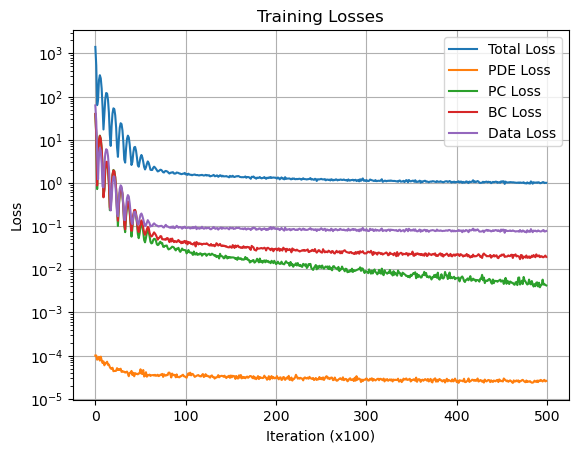

In [32]:
# plot losses
import matplotlib.pyplot as plt
plt.semilogy(model.loss_log, label='Total Loss')
plt.semilogy(model.loss_res, label='PDE Loss')
plt.semilogy(model.loss_pc_log, label='PC Loss')
plt.semilogy(model.loss_bc_log, label='BC Loss')
plt.semilogy(model.loss_data_log, label='Data Loss')
plt.xlabel('Iteration (x100)')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.title('Training Losses')
plt.show()

In [29]:
# Ejemplo de predicción en un modelo específico y puntos dados
params = model.get_params(model.opt_state)
n_test = 1
u_test = jnp.array(vel_flat[n_test])  # (m,)

# Puntos (x,z,t) para evaluar
x_test = np.linspace(0, Nx-1, 70)
z_test = np.linspace(0, Nz-1, 70)
t_ = 150
t_test = np.array([t_], dtype=np.float32)

Xg, Zg, Tg = np.meshgrid(x_test, z_test, t_test, indexing="ij")
XZT_star = np.stack([Xg.flatten(), Zg.flatten(), Tg.flatten()], axis=1).astype(np.float32)
U_star   = np.tile(np.array(vel_flat[n_test], dtype=np.float32), (XZT_star.shape[0], 1))

p_pred = model.predict_p(params, jnp.array(U_star), jnp.array(XZT_star))
p_pred = np.array(p_pred).reshape(len(x_test), len(z_test), len(t_test))

print(f"Predicción p(x,z,t={t_}) de shape:", p_pred.shape)

Predicción p(x,z,t=150) de shape: (70, 70, 1)


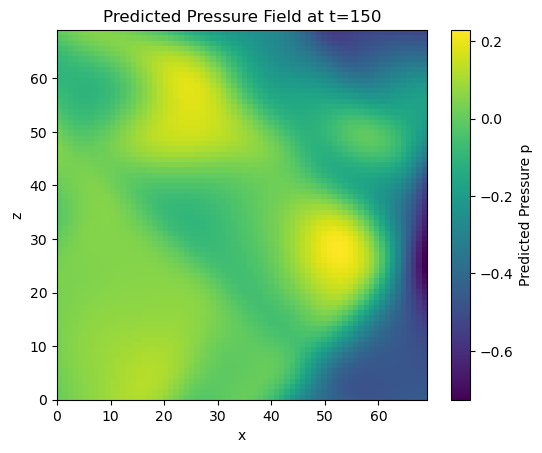

In [30]:
# plot prediction
import matplotlib.pyplot as plt
plt.imshow(p_pred[:, :, 0], extent=[0, Nx-1, 0, Nz-1], origin='lower')
plt.colorbar(label='Predicted Pressure p')
plt.xlabel('x')
plt.ylabel('z')
plt.title(f'Predicted Pressure Field at t={t_}')
plt.show()

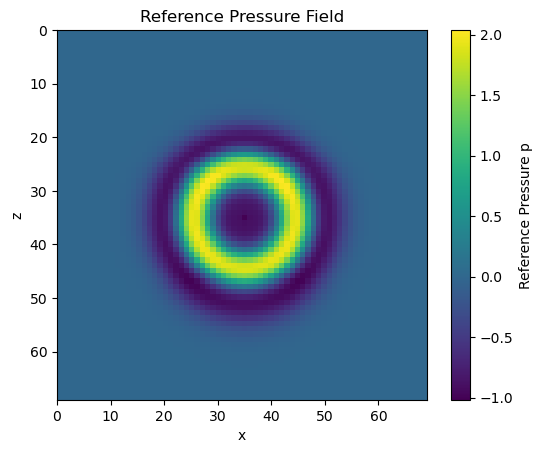

In [31]:
# plot reference output
p_ref = wave_field[n_test, t_, :, :]  # (Nz, Nx)
plt.imshow(p_ref, extent=[0, Nx-1, Nz-1, 0], origin='upper')
plt.colorbar(label='Reference Pressure p')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Reference Pressure Field')
plt.show()

In [11]:
mse = np.mean((p_pred[:, :, 0] - p_ref)**2)
print(f"MSE entre predicción y referencia: {mse}")

MSE entre predicción y referencia: 0.8083990216255188


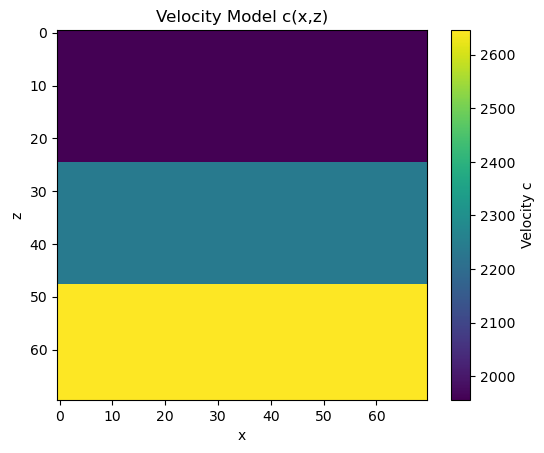

In [12]:
# plot model velocity
plt.imshow(vel_flat[n_test].reshape(Nz, Nx), origin='upper')
plt.colorbar(label='Velocity c')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Velocity Model c(x,z)')
plt.show()
